### Purpose: 

we use the covergae score to first filter for high quality text, and then we take the high quality text to later combine the reference text to better optimize and train the classifier and LDA model to help return more accurate result when apply to the new docs (test set)

can thn choose our dataset from the "perfect" video for validation later 

Train/test split process is important to optimize the quality of the trained model

1. based on the coverage model result, segment the quality of the video transcript into 5 categories:
    
- Excelent:  90-100%

- Good: 75-89%

- Medium: 50-74%

- low: 25-50%

- bad: 0-25%


2. Shuffle the "Excelent" + "Good" + "Medium" transcript text with 80/20 Train/test ratio that will get later fed to train the model

- keep out the video transcript(cleint sent) used for later validation purposes

the 80 % of the good quality transcript will be used to train classifier NB model

- "Excelent" + "Good"  video transcript will combimed with the reference text and get used to train the classifier model 


3. Shuffle the "Excelent" + "Good" transcript text with 80/20 Train/test ratio that will get later fed to train the LDA subtopic model

- "Excelent" + "Good" video transcript will combimed with the reference text and get used to train the subtopic extraction model 



In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
coverage_text_pd = pd.read_csv('model_output_dataset/coverage_measure_output_text.csv').drop('Unnamed: 0', axis = 1)

df = pd.read_csv("ready_for_model_dataset/ready_for_model.csv").drop('Unnamed: 0', axis = 1)

In [3]:
main_topics_lst = list(coverage_text_pd.main_topics.unique())

coverage_text_pd.head()

,Video_ID,final_corrected_version_txt,reference_text_cleaned,main_topics,Count_Vector_Cosine_Similarity,TFIDF_Vector_Cosine_Similarity,Word_Vector_Cosine_Similarity,Avg_Cosine_Similarity
0,VVX9M6WYCjo,[Music]. ants. ants all around. do you know ho...,Ants are one of the most common insects that l...,insect_ant,0.856380,0.778180,0.974109,0.869556
1,zL7VIomiiyg,today we're going to learn all about. ants. oh...,Ants are one of the most common insects that l...,insect_ant,0.828937,0.740823,0.939397,0.836386
2,birds_intro_flamingo_v,Let's learn about flamingos flamingos are tall...,Flamingo Flamingo is about 110 to 150 cm tall ...,bird_flamingo,0.762279,0.646343,0.955252,0.787958
3,_gs4XfbYPKc,You're watching FreeSchool!. Let's learn about...,Flamingo Flamingo is about 110 to 150 cm tall ...,bird_flamingo,0.766463,0.644687,0.945320,0.785490
4,FMjppU6AKBQ,did you know that there's a popular bird. name...,Flamingo Flamingo is about 110 to 150 cm tall ...,bird_flamingo,0.765567,0.665743,0.906376,0.779229


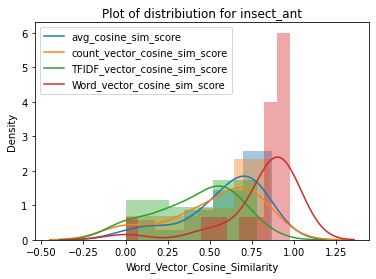

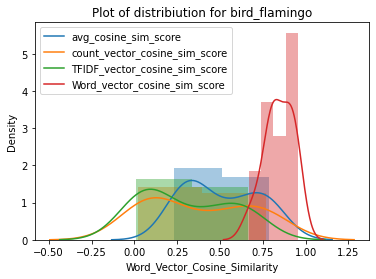

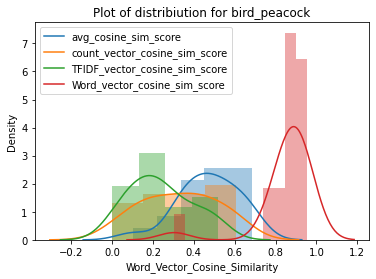

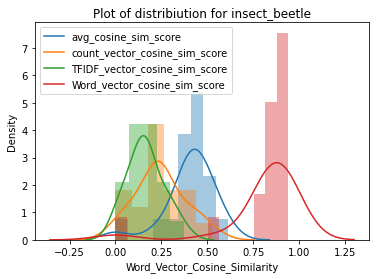

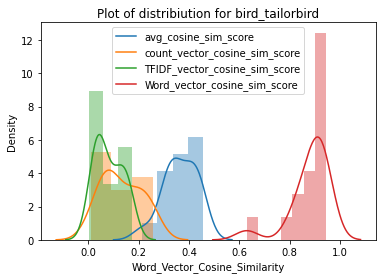

In [4]:
for topic in main_topics_lst:
    
    x_avg = coverage_text_pd[coverage_text_pd.main_topics == topic]['Avg_Cosine_Similarity']
    x_count_vector = coverage_text_pd[coverage_text_pd.main_topics == topic]['Count_Vector_Cosine_Similarity']
    x_TFIDF_vector = coverage_text_pd[coverage_text_pd.main_topics == topic]['TFIDF_Vector_Cosine_Similarity']
    x_word_vector = coverage_text_pd[coverage_text_pd.main_topics == topic]['Word_Vector_Cosine_Similarity']
    ax = sns.distplot(x_avg).set(title='Plot of distribiution for {}'.format(topic))
    ax = sns.distplot(x_count_vector)
    ax = sns.distplot(x_TFIDF_vector)
    ax = sns.distplot(x_word_vector)
    ax.legend(labels=['avg_cosine_sim_score','count_vector_cosine_sim_score', 'TFIDF_vector_cosine_sim_score', 'Word_vector_cosine_sim_score'])
    plt.show()

In [5]:
# 1. label each main topics's text transcript based on its coveragae score's distribution quantile 

# leave out the client sent videos transcript

def coverage_quality(qtl):
    
    if qtl >= 90 and qtl <= 100:
        
        return "excellent"
    if qtl >= 75 and qtl <= 89:
        
        return "good"
    
    if qtl >= 50 and qtl <= 74:
        
        return "medium"
    
    if qtl >= 25 and qtl <= 50:
        
        return "low"
    
    if qtl >= 0 and qtl <= 25:
        
        return "bad"

coverage_text_pd_new = pd.DataFrame()    
for topic in main_topics_lst:
    
    Df_topic = coverage_text_pd[coverage_text_pd.main_topics == topic]

    sz = Df_topic['Avg_Cosine_Similarity'].size-1
    
    Df_topic['Percentile'] = Df_topic['Avg_Cosine_Similarity'].rank(method='max').apply(lambda x: np.round(100.0*(x-1)/sz, 2))
    
    Df_topic['coverage_quality'] = Df_topic['Percentile'].apply(lambda x: coverage_quality(x))
    
    coverage_text_pd_new = pd.concat([coverage_text_pd_new, Df_topic], axis = 0)
    
coverage_text_pd_new.head()


,Video_ID,final_corrected_version_txt,reference_text_cleaned,main_topics,Count_Vector_Cosine_Similarity,TFIDF_Vector_Cosine_Similarity,Word_Vector_Cosine_Similarity,Avg_Cosine_Similarity,Percentile,coverage_quality
0,VVX9M6WYCjo,[Music]. ants. ants all around. do you know ho...,Ants are one of the most common insects that l...,insect_ant,0.856380,0.778180,0.974109,0.869556,100.00,excellent
1,zL7VIomiiyg,today we're going to learn all about. ants. oh...,Ants are one of the most common insects that l...,insect_ant,0.828937,0.740823,0.939397,0.836386,94.74,excellent
5,CASrmm4BUJk,[Music]. hi[Music]. did you find an anthill Wo...,Ants are one of the most common insects that l...,insect_ant,0.729156,0.594375,0.966673,0.763402,89.47,None
6,9SPixBok5ls,[Music]. they're tiny but might and when hundr...,Ants are one of the most common insects that l...,insect_ant,0.735382,0.626153,0.928374,0.763303,84.21,good
7,2IVb2Atu3Jc,Squeaks and I just got back from a picnic\nout...,Ants are one of the most common insects that l...,insect_ant,0.721705,0.619941,0.926353,0.756000,78.95,good


In [6]:
# return the count distribution for the coverage quanlity label

coverage_text_pd_new['coverage_quality'].value_counts()

medium       23
bad          23
low          21
good         11
excellent    10
Name: coverage_quality, dtype: int64

In [7]:
# 0. seperate out the videos will be used for validation outside of the test and train

valdiated_set = pd.DataFrame(coverage_text_pd_new[coverage_text_pd_new.Video_ID.str.endswith("_v")][['Video_ID', 'coverage_quality']].drop_duplicates())


In [8]:
valdiated_set

,Video_ID,coverage_quality
11,insects_intro_ant_v,medium
2,birds_intro_flamingo_v,excellent
18,birds_intro_peacock_v,None
30,insects_intro_beetle_v,good
45,birds_intro_tailor_bird_v,excellent


In [9]:
df.head()

,Title,Video_ID,Category,Age_Restricted,final_corrected_version_sentences_txt,final_corrected_version_txt,sentence_level_timstamp_min_sec,sentence_level_timstamp_max_sec,sentence_level_timstamp_min_minute,sentence_level_timstamp_max_minute,duration,Length_(min),Views_(thous),main_topics,reference_text,reference_text_cleaned
0,Children Learn About The Ant,cXUCUvcscXs,Ant,False,welcome to my tree house come and look,welcome to my tree house come and look. at thi...,0.560,4.080,0.009333,0.068000,3.520,5.333333,921.491,insect_ant,['Ants are one of the most common insects that...,Ants are one of the most common insects that l...
1,Children Learn About The Ant,cXUCUvcscXs,Ant,False,at this,welcome to my tree house come and look. at thi...,2.560,6.080,0.042667,0.101333,3.520,5.333333,921.491,insect_ant,['Ants are one of the most common insects that...,Ants are one of the most common insects that l...
2,Children Learn About The Ant,cXUCUvcscXs,Ant,False,this is my ant farm,welcome to my tree house come and look. at thi...,4.080,8.639,0.068000,0.143983,4.559,5.333333,921.491,insect_ant,['Ants are one of the most common insects that...,Ants are one of the most common insects that l...
3,Children Learn About The Ant,cXUCUvcscXs,Ant,False,ants are amazing creatures lots of,welcome to my tree house come and look. at thi...,6.080,10.559,0.101333,0.175983,4.479,5.333333,921.491,insect_ant,['Ants are one of the most common insects that...,Ants are one of the most common insects that l...
4,Children Learn About The Ant,cXUCUvcscXs,Ant,False,insects live by themselves and have to,welcome to my tree house come and look. at thi...,8.639,12.880,0.143983,0.214667,4.241,5.333333,921.491,insect_ant,['Ants are one of the most common insects that...,Ants are one of the most common insects that l...


In [10]:
validation_text_lvl_df = pd.merge(df, valdiated_set, 'inner', left_on = 'Video_ID', right_on = 'Video_ID' )
print(validation_text_lvl_df.shape)

(123, 17)


In [11]:
# # generate the datset for later train/test split
coverage_text_pd_new = coverage_text_pd_new[~coverage_text_pd_new.Video_ID.str.endswith("_v")]

In [12]:
validation_text_lvl_df.to_csv('ready_for_model_dataset/validation_df.csv')

In [13]:
# 2. first, shuffle samples with labeled "excellent" + "good" + "medium" for classiifer model train 80-20 ratio

#  join with the Text level, and keep the video ids 

coverage_text_pd_new_classifier_forsplit = coverage_text_pd_new[coverage_text_pd_new['coverage_quality'].isin(['excellent', 'good'])][["Video_ID", 'coverage_quality']].drop_duplicates()

from sklearn.model_selection import train_test_split

train_classifier, test_classifier = train_test_split(coverage_text_pd_new_classifier_forsplit, test_size=0.2)

print(len(train_classifier.Video_ID.unique()))
print(len(test_classifier.Video_ID.unique()))

14
4


In [14]:
df_classifier_train = df[df['Video_ID'].isin(list(train_classifier.Video_ID.unique()))]

pd.merge(df_classifier_train, pd.DataFrame(train_classifier), 'left', 'Video_ID')

df_classifier_test = df[(~df['Video_ID'].isin(list(train_classifier.Video_ID.unique())))]

df_classifier_test = pd.merge(df_classifier_test, \
                              coverage_text_pd_new[(~coverage_text_pd_new['Video_ID'].isin(list(train_classifier.Video_ID.unique())))][['Video_ID','coverage_quality' ]].drop_duplicates(), \
                              'left', 'Video_ID')
df_classifier_test = pd.concat([df_classifier_test, validation_text_lvl_df ], axis = 0)

print(len(df.Video_ID.unique()))
print(len(df_classifier_train.Video_ID.unique()))
print(len(df_classifier_test.Video_ID.unique()))

90
14
76


In [15]:
df_classifier_train.to_csv('ready_for_model_dataset/df_train.csv')
df_classifier_test.to_csv('ready_for_model_dataset/df_test.csv')